In [130]:
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import compress_pickle

from hpc_inspect.inspector import *

In [160]:
data = compress_pickle.load('dataframe.pickle.lzma')
#data.set_index(['pmodel', 'compiler', 'incore_model', 'cores', 'define'], inplace=True)
compilers = [cc for cc in data.compiler.unique() if cc is not None]
incore_models = [icm for icm in data.incore_model.unique() if icm is not None]
cache_predictors = [cp for cp in data.cache_predictor]

In [159]:
data.columns

Index(['job', 'pmodel', 'cores', 'compiler', 'incore_model', 'cache_predictor',
       'L1 LCs', 'L2 LCs', 'L3 LCs', 'raw output', 'define',
       'iterations per cacheline', 'performance [cy/CL]',
       'performance [cy/It]', 'performance [FLOP/s]', 'performance [LUP/s]',
       'performance [It/s]', 'T unit', 'T_comp', 'T_RegL1', 'T_L1L2', 'T_L2L3',
       'T_L3MEM', 'memory bandwidth [GB/s]', 'B unit', 'in-core model output'],
      dtype='object')

## Stencil Properties

In [167]:
# TODO present origin and property of kernel code
iterations_per_cacheline = int(data.get('iterations per cacheline').dropna().unique()[0])

## Kernel Source Code

In [134]:
print(data.iloc[0].job.workload.kernel.get_code())

double a[N], b[N], c[N];

for(int i=0; i<N; ++i)
    a[i] = b[i] + c[i];



### In-Core Analysis

In [135]:
# Get analysis alongside with assembly for each compiler and in-core model
for cc in compilers:
    for icm in incore_models:
        print('####', cc, icm)
        print(data.query("compiler == @cc and incore_model == @icm")['in-core model output'].unique()[0])

#### gcc IACA
Intel(R) Architecture Code Analyzer Version - 2.3 build:246dfea (Thu, 6 Jul 2017 13:38:05 +0300)
Analyzed File - .kernel.c_kerncraft/machine.yml/gcc/-O3_-march=corei7-avx_-D_POSIX_C_SOURCE=200809L_-fopenmp_-lm/kernel-marked.o
Binary Format - 64Bit
Architecture  - IVB
Analysis Type - Throughput

Throughput Analysis Report
--------------------------
Block Throughput: 3.05 Cycles       Throughput Bottleneck: FrontEnd

Port Binding In Cycles Per Iteration:
-------------------------------------------------------------------------
|  Port  |  0   -  DV  |  1   |  2   -  D   |  3   -  D   |  4   |  5   |
-------------------------------------------------------------------------
| Cycles | 0.9    0.0  | 1.0  | 2.5    2.0  | 2.5    2.0  | 2.0  | 3.0  |
-------------------------------------------------------------------------

N - port number or number of cycles resource conflict caused delay, DV - Divider pipe (on port 0)
D - Data fetch pipe (on ports 2 and 3), CP - on a critical p

## Layer Conditions

In [161]:
# TODO readout and present LCs
data.columns

Index(['job', 'pmodel', 'cores', 'compiler', 'incore_model', 'cache_predictor',
       'L1 LCs', 'L2 LCs', 'L3 LCs', 'raw output', 'define',
       'iterations per cacheline', 'performance [cy/CL]',
       'performance [cy/It]', 'performance [FLOP/s]', 'performance [LUP/s]',
       'performance [It/s]', 'T unit', 'T_comp', 'T_RegL1', 'T_L1L2', 'T_L2L3',
       'T_L3MEM', 'memory bandwidth [GB/s]', 'B unit', 'in-core model output'],
      dtype='object')

## Single Core Grid Scaling

### ECM Prediction vs Performance

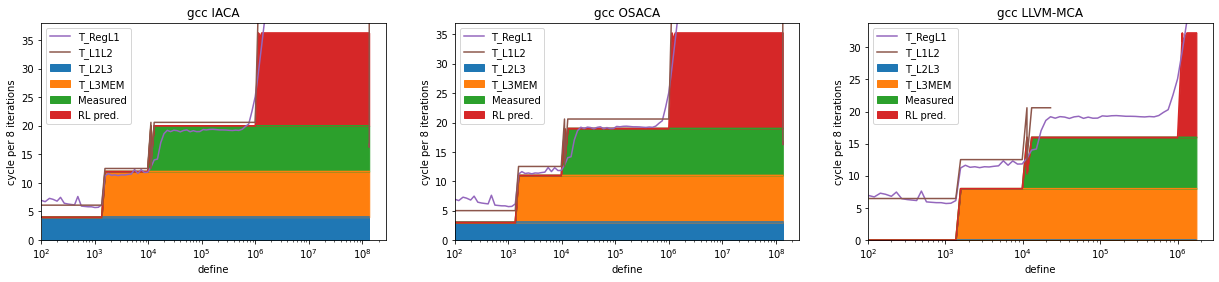

In [162]:
fig, axs = mpl.pyplot.subplots(len(compilers), len(incore_models), squeeze=False,
                               figsize=(7*len(incore_models),4*len(compilers)))
for i_cc, cc in enumerate(compilers):
    for i_icm, icm in enumerate(incore_models):
        ax = axs[i_cc, i_icm]
        ax.set_title("{} {}".format(cc, icm))
        ax.set_ylabel("cycle per {} iterations".format(iterations_per_cacheline))
        ax.set_xlabel("")
        ecm_data = data.query('pmodel=="ECM" and cores==1 and incore_model == @icm')
        ecm_data.plot.area(
            y=['T_RegL1', 'T_L1L2', 'T_L2L3', 'T_L3MEM'], x='define', logx=True, xlim=100, ylim=0, ax=ax)
        data.query('pmodel=="Benchmark" and cores==1').plot(
            y='performance [cy/CL]', x='define', logx=True, xlim=100, ylim=0, label='Measured', ax=ax)
        data.query('pmodel=="RooflineIACA" and incore_model == @icm').plot(
            y='performance [cy/CL]', x='define', logx=True, xlim=100, ylim=0, label='RL pred.', ax=ax)
# TODO improve legend (and reduce to one)
# TODO name columns and rows
# TODO fix scale/limits to show all available data
# TODO add It/s, flop/s axis to right
# TODO find good metric (or name) for x-axis

### Data Transfers

In [165]:
for cp in cache_predictors:
    data.query('cache_predictor==@cp')

# TODO include predicted information into pandas
# TODO include measured informatin into pandas (inspector.py:574)

## Multi Core Thread Sacling

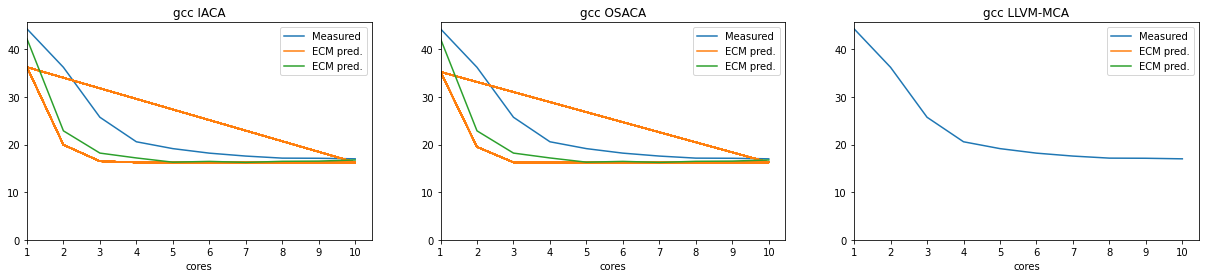

In [166]:
fig, axs = mpl.pyplot.subplots(len(compilers), len(incore_models), squeeze=False,
                               figsize=(7*len(incore_models),4*len(compilers)))
max_define = data.define.max()
for i_cc, cc in enumerate(compilers):
    for i_icm, icm in enumerate(incore_models):
        ax = axs[i_cc, i_icm]
        ax.set_title("{} {}".format(cc, icm))
        data.query('pmodel=="Benchmark" and define==@max_define').plot(
            x='cores', y='performance [cy/CL]', xlim=1, ylim=0, legend=True, label='Measured', ax=ax)
        data.query('pmodel=="ECM" and define==@max_define and incore_model==@icm').plot(
            x='cores', y='performance [cy/CL]', xlim=1, ylim=0, legend=True, label='ECM pred.', ax=ax)
        data.query('pmodel=="RooflineIACA" and define==@max_define and incore_model==@icm').plot(
            x='cores', y='performance [cy/CL]', xlim=1, ylim=0, legend=True, label='ECM pred.', ax=ax)
        ax.set_xticks(range(int(data.cores.min()), int(data.cores.max() + 1)))
# TODO find issue with ECM scaling curve

## System Information

In [164]:
# TODO collect and present machine state

# Notebook things to look at:
 * https://github.com/nteract/papermill
 * https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
